#Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

#Load and Explore the Dataset

In [2]:
data = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv", encoding='ISO-8859-1')
data.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


#Data Preprocessing


In [3]:
print(data.columns)

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [5]:
# Drop unnecessary columns
data = data.drop(columns=['emotion_in_tweet_is_directed_at'])

In [6]:
# Rename columns
data.rename(columns={'tweet_text': 'text',
                     'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)


In [7]:
# Check for missing values
print("Missing values:", data.isnull().sum())

Missing values: text         1
sentiment    0
dtype: int64


In [8]:
# Drop rows with missing values in the 'text' column
data = data.dropna(subset=['text'])

In [9]:
print("Missing values after dropping:", data.isnull().sum())

Missing values after dropping: text         0
sentiment    0
dtype: int64


#Encode

In [35]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Verify the data type and samples
print("y_train data type:", y_train.dtype)
print("y_train sample:", y_train[:5])
print("Class distribution in training set:", np.bincount(y_train))
print("Class distribution in testing set:", np.bincount(y_test))


y_train data type: int64
y_train sample: [2 2 1 2 2]
Class distribution in training set: [ 125  456 4310 2382]
Class distribution in testing set: [  31  114 1078  596]


In [33]:
# Display the mapping of classes to integers
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Mapping: {"I can't tell": 0, 'Negative emotion': 1, 'No emotion toward brand or product': 2, 'Positive emotion': 3}


In [28]:
# Split the data into features (text) and target (sentiment)
X = data['text'].values
y = data['sentiment'].values

In [29]:
# Display a few samples to confirm the encoding
print("Sample texts:", X[:5])
print("Sample encoded sentiments:", y[:5])

Sample texts: ['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.'
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw"
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]
Sample encoded sentiments: [1 3 3 1 3]


#Tokenize and Padding

In [10]:
# Define the maximum number of words to keep in the vocabulary and the maximum sequence length
MAX_WORDS = 10000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum number of words per tweet

In [11]:
# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['text'])

In [12]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['text'])

In [13]:
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [14]:
# Check the shape of the padded sequences
print("Shape of padded sequences:", padded_sequences.shape)

Shape of padded sequences: (9092, 100)


#Split the Dataset into Training and Testing Sets

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['sentiment'],
                                                    test_size=0.2, random_state=42, stratify=data['sentiment'])

In [16]:
# Check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (7273, 100) (7273,)
Testing set shape: (1819, 100) (1819,)


#Build the LSTM Model

In [19]:
# Define the LSTM model
model = Sequential([

    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: positive, negative, neutral, no_idea
])

In [22]:
model.build(input_shape=(None, 100))  # (batch_size, sequence_length)

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,412,100 (5.39 MB)

 Trainable params: 1,412,100 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

#Train the LSTM Model

In [36]:
# Train the model with 5 epochs
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.5689 - loss: 0.9876 - val_accuracy: 0.6082 - val_loss: 0.8996
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.5891 - loss: 0.9483 - val_accuracy: 0.6082 - val_loss: 0.8882
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.5765 - loss: 0.9494 - val_accuracy: 0.6082 - val_loss: 0.8950
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 38s 206ms/step - accuracy: 0.5853 - loss: 0.9396 - val_accuracy: 0.6082 - val_loss: 0.8910
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.6003 - loss: 0.9232 - val_accuracy: 0.6082 - val_loss: 0.9040
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step - accuracy: 0.5849 - loss: 0.9318 - val_accuracy: 0.6082 - val_loss: 0.8888
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.5837 - loss: 0.9491 - val_accuracy: 0.6082 - val_loss: 0.8898
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.5854 - loss: 0

#Evaluate the Model on the Test Set

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5993 - loss: 0.9078
Test Loss: 0.9204967021942139
Test Accuracy: 0.5926333069801331


#Visualize Training History

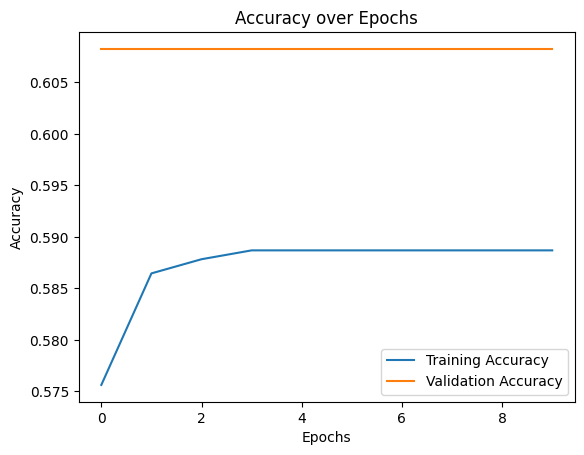

In [38]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

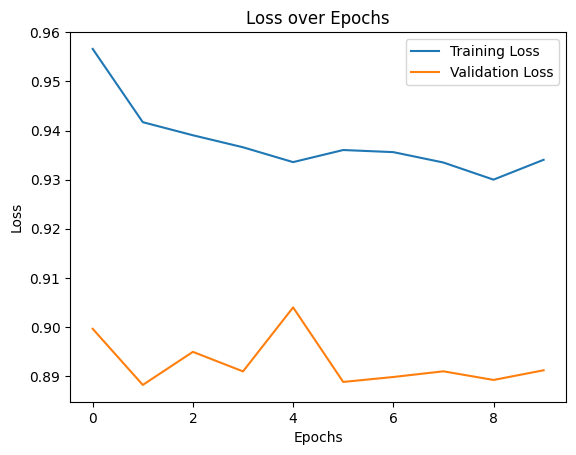

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Observations



1.   **Accuracy Plot:**


*   Training accuracy shows improvement over epochs, stabilizing around 0.6.
*   Validation accuracy remains flat, suggesting the model might not generalize well.


2.   **Loss Plot:**


*   Training loss decreases gradually, indicating the model is learning.
*   Validation loss fluctuates, suggesting the model may not be learning the validation data well




#Hyperparameter Tuning

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
# Define hyperparameter ranges
lstm_units = [64, 128, 256]
batch_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5, 0.7]
learning_rates = [0.001, 0.0005]

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [45]:
results = []

In [47]:
# Hyperparameter tuning loop
for units in lstm_units:
    for batch_size in batch_sizes:
        for dropout_rate in dropout_rates:
            for lr in learning_rates:
                print(f"Testing with LSTM units={units}, batch_size={batch_size}, dropout_rate={dropout_rate}, learning_rate={lr}")

                # Build model
                model = Sequential([
                    Embedding(input_dim=10000, output_dim=128, input_length=100),
                    LSTM(units),
                    Dropout(dropout_rate),
                    Dense(4, activation='softmax')
                ])
                # Compile model with the current learning rate
                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                # Train model
                history = model.fit(
                    X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1
                    )

                # Evaluate model
                loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
                print(f"Test Loss: {loss}, Test Accuracy: {accuracy}\n")

                # Save results
                results.append({
                    'units': units,
                    'batch_size': batch_size,
                    'dropout_rate': dropout_rate,
                    'learning_rate': lr,
                    'test_loss': loss,
                    'test_accuracy': accuracy
                })




Testing with LSTM units=64, batch_size=16, dropout_rate=0.3, learning_rate=0.001
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


364/364 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.5685 - loss: 0.9787 - val_accuracy: 0.6082 - val_loss: 0.8871
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.5938 - loss: 0.9330 - val_accuracy: 0.6082 - val_loss: 0.8965
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.5850 - loss: 0.9423 - val_accuracy: 0.6082 - val_loss: 0.8902
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.5936 - loss: 0.9226 - val_accuracy: 0.6082 - val_loss: 0.8939
Test Loss: 0.9224043488502502, Test Accuracy: 0.5926333069801331

Testing with LSTM units=64, batch_size=16, dropout_rate=0.3, learning_rate=0.0005
Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.5655 - loss: 1.0070 - val_accuracy: 0.6082 - val_loss: 0.8901
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.5991 - loss: 0.9164 - val_accuracy: 0.6082 - val_loss: 0.8964
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.5904 - loss: 0.

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df = results_df.sort_values(by='test_accuracy', ascending=False)

In [ ]:
# Display the top 5 configurations
print("Top 5 configurations:")
print(results_df.head())